In [1]:
import wooldridge as woo
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns
import gretltests
import matplotlib.pyplot as plt
import numpy as np
import augmentdata
from OLSAR1 import *

plt.rcParams['figure.figsize'] = [15, 6]


from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA

# Session 17 Slides

<AxesSubplot:>

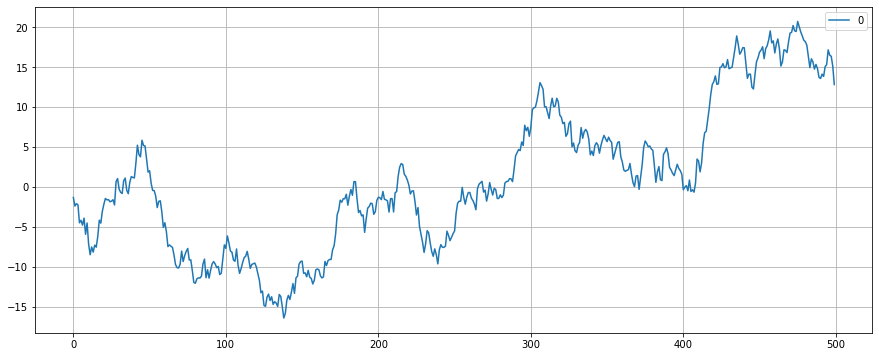

In [2]:
#To generate a AR1 series, you can change the following parameters
alpha1=1
alpha0=0
gama=.0


T=500    #The sample size
t=np.arange(T)
u=np.random.normal(0,1,T)
y=[]
for i in range(T):
    if i==0:
       if alpha1<1: 
           e=alpha0/(1-alpha1)+u[i]
       else:
           e=alpha0+u[i]
    else:
       e=alpha0+alpha1*e+gama*t[i]+u[i]
    y=y+[e]
pd.DataFrame(y).plot(grid=True)

In [3]:
nyse=woo.data('nyse')
woo.data('nyse',description=True)
nyse['lprice']=np.log(nyse['price'])

name of dataset: nyse
no of variables: 8
no of observations: 691

+----------+------------------------+
| variable | label                  |
+----------+------------------------+
| price    | NYSE stock price index |
| return   | 100*(p - p(-1))/p(-1)) |
| return_1 | lagged return          |
| t        |                        |
| price_1  |                        |
| price_2  |                        |
| cprice   | price - price_1        |
| cprice_1 | lagged cprice          |
+----------+------------------------+

These are Wednesday closing prices of value-weighted NYSE average,
available in many publications. I do not recall the particular source
I used when I collected these data at MIT. Probably the easiest way to
get similar data is to go to the NYSE web site, www.nyse.com.


<AxesSubplot:>

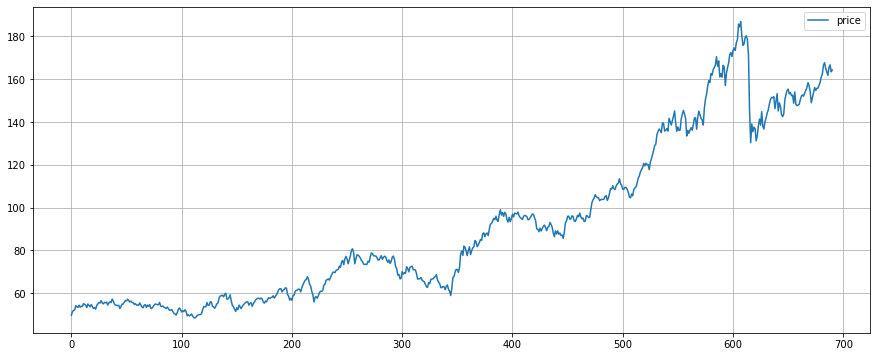

In [4]:
nyse.plot(y='price',grid=True)

<AxesSubplot:>

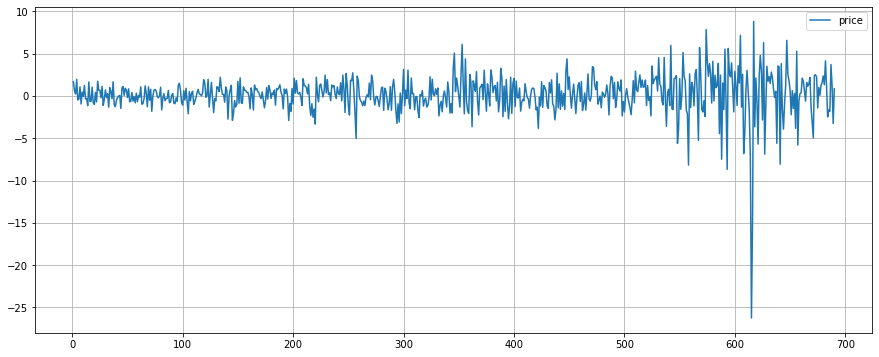

In [5]:
nyse.diff().plot(y='price',grid=True)

In [6]:
from statsmodels.tsa.arima.model import ARIMA

In [7]:
#Produces a slightly different result than gretl
#Note that the enforce invertibility statement plays a rold for model 2
mod1 = ARIMA(nyse['lprice'], order=(1, 1, 1),trend='c',enforce_invertibility=True)
#mod2 = ARIMA(nyse['lprice'], order=(1, 1, 1),enforce_invertibility=False)
res1 = mod1.fit()
#res2 = mod2.fit()wapltwa
print(res1.summary())
#print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:                 lprice   No. Observations:                  691
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1678.799
Date:                Sat, 07 Jan 2023   AIC                          -3349.599
Time:                        09:22:46   BIC                          -3331.452
Sample:                             0   HQIC                         -3342.579
                                - 691                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.059e-08   1.15e-12  -1.79e+04      0.000   -2.06e-08   -2.06e-08
ar.L1         -0.7189      0.134     -5.354      0.000      -0.982      -0.456
ma.L1          0.7897      0.127      6.222      0.0

In [8]:
wageprc=woo.data('wageprc')
woo.data('wageprc',description=True)

name of dataset: wageprc
no of variables: 20
no of observations: 286

+----------+----------------------------+
| variable | label                      |
+----------+----------------------------+
| price    | consumer price index       |
| wage     | nominal hourly wage        |
| t        | time trend = 1, 2 , 3, ... |
| lprice   | log(price)                 |
| lwage    | log(wage)                  |
| gprice   | lprice - lprice[_n-1]      |
| gwage    | lwage - lwage[_n-1]        |
| gwage_1  | gwage[_n-1]                |
| gwage_2  | gwage[_n-2]                |
| gwage_3  |                            |
| gwage_4  |                            |
| gwage_5  |                            |
| gwage_6  |                            |
| gwage_7  |                            |
| gwage_8  |                            |
| gwage_9  |                            |
| gwage_10 |                            |
| gwage_11 |                            |
| gwage_12 |                            |
| gpri

<AxesSubplot:>

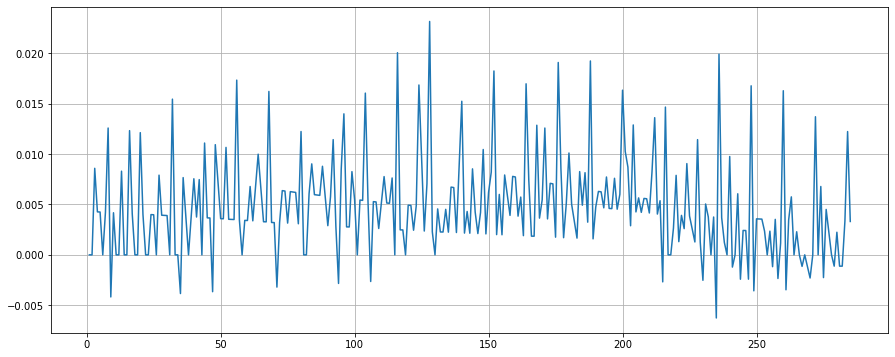

In [9]:
wageprc['gwage'].plot(grid=True)

In [10]:
month=[]
T=len(wageprc)
for j in range(round(T/12)):
    for i in range(1,13):
        month=month+[i]
month=month[0:T]
wageprc['month']=month
wageprc_=pd.get_dummies(wageprc, prefix='m', columns=['month'])
wageprc_.columns

Index(['price', 'wage', 't', 'lprice', 'lwage', 'gprice', 'gwage', 'gwage_1',
       'gwage_2', 'gwage_3', 'gwage_4', 'gwage_5', 'gwage_6', 'gwage_7',
       'gwage_8', 'gwage_9', 'gwage_10', 'gwage_11', 'gwage_12', 'gprice_1',
       'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10',
       'm_11', 'm_12'],
      dtype='object')

In [11]:
form='gwage~gwage_1'
for i in range(11):
    form=form+'+m_'+str(i+1)
mod0=ols(form,data=wageprc_).fit()
print(mod0.summary())


                            OLS Regression Results                            
Dep. Variable:                  gwage   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     27.49
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           3.05e-40
Time:                        09:22:47   Log-Likelihood:                 1221.6
No. Observations:                 284   AIC:                            -2417.
Df Residuals:                     271   BIC:                            -2370.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.001      2.387      0.0

In [12]:
form='gwage~gwage_1'
for i in range(12):
    form=form+'+gwage_'+str(i+1)
mod1=ols(form,data=wageprc_).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:                  gwage   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     24.71
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           1.68e-36
Time:                        09:22:47   Log-Likelihood:                 1169.3
No. Observations:                 273   AIC:                            -2313.
Df Residuals:                     260   BIC:                            -2266.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.001      1.438      0.1

In [13]:
greene=pd.read_csv('greene11_3.csv')
greene.index=greene['obs']
greene['time']=np.arange(1,len(greene)+1)

In [14]:
mod2=ols('C~Y',data=greene).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.359e+04
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           6.61e-50
Time:                        09:22:48   Log-Likelihood:                -155.71
No. Observations:                  36   AIC:                             315.4
Df Residuals:                      34   BIC:                             318.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.3737      9.629      1.181      0.2

In [15]:
mod2=ols('C~Y+time',data=greene).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.147e+04
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           1.25e-47
Time:                        09:22:48   Log-Likelihood:                -155.68
No. Observations:                  36   AIC:                             317.4
Df Residuals:                      33   BIC:                             322.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.5781     32.511      0.571      0.5

In [16]:
mod3=OLSAR1(mod2)
print(mod3.summary())

Rho =  0.6981653399026658
Rho =  0.7404065178920006
Rho =  0.761412872312939
Rho =  0.7731967226461889
Rho =  0.7803238523133863
Rho =  0.7848419963436232
Rho =  0.7877937129489261
Rho =  0.7897604601630532
Rho =  0.7910882409143023
Rho =  0.7919926250750021
Rho =  0.7926123505117373
Rho =  0.7930387727869282
Rho =  0.7933330214094614
Rho =  0.7935364632205203
Rho =  0.7936773124163549
Rho =  0.7937749182589557
Rho =  0.7938426012376381
Rho =  0.7938895559067922
Rho =  0.7939221406156285
Rho =  0.7939447580374448
Rho =  0.7939604594140067
Rho =  0.7939713607003337
Rho =  0.7939789298880284
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     894.7
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           8.24e-29
Time:   

In [17]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(greene,y='C',x=['Y'],maxlag=[1,1])
formula=formula+'+time' #add on any non-lagged explanatory variables
mod4=ols(formula,data=dat).fit()
print(mod4.summary())
formula

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8137.
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           4.64e-45
Time:                        09:22:48   Log-Likelihood:                -143.06
No. Observations:                  35   AIC:                             296.1
Df Residuals:                      30   BIC:                             303.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2237     27.986      0.866      0.3

'C~+C_1+Y+Y_1+time'

In [18]:
#The long run coefficient is:
b=mod4.params
(b['Y']+b['Y_1'])/(1-b['C_1'])

0.7642759522085102

# Session 17 Interactive

In [19]:
hseinv=woo.data('hseinv')
woo.data('hseinv',description=True)
hseinv.index=hseinv['year']

name of dataset: hseinv
no of variables: 14
no of observations: 42

+----------+-------------------------------+
| variable | label                         |
+----------+-------------------------------+
| year     | 1947-1988                     |
| inv      | real housing inv, millions $  |
| pop      | population, 1000s             |
| price    | housing price index; 1982 = 1 |
| linv     | log(inv)                      |
| lpop     | log(pop)                      |
| lprice   | log(price)                    |
| t        | time trend: t=1,...,42        |
| invpc    | per capita inv: inv/pop       |
| linvpc   | log(invpc)                    |
| lprice_1 | lprice[_n-1]                  |
| linvpc_1 | linvpc[_n-1]                  |
| gprice   | lprice - lprice_1             |
| ginvpc   | linvpc - linvpc_1             |
+----------+-------------------------------+

D. McFadden (1994), “Demographics, the Housing Market, and the Welfare
of the Elderly,” in D.A. Wise (ed.), Studies in th

In [20]:
mod5=ols('linvpc~lprice+t',data=hseinv).fit()
mod6=OLSAR1(mod5)
print(mod6.summary())

Rho =  0.4964827988341621
Rho =  0.5025808584772283
Rho =  0.5037707633620897
Rho =  0.504005495762464
Rho =  0.5040518995063022
Rho =  0.5040610767888399
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.606
Date:                Sat, 07 Jan 2023   Prob (F-statistic):             0.0870
Time:                        09:22:48   Log-Likelihood:                 28.283
No. Observations:                  41   AIC:                            -50.57
Df Residuals:                      38   BIC:                            -45.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

In [21]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[0,1])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod7=ols(formula,data=dat).fit()
print(mod7.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     15.96
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           8.09e-07
Time:                        09:22:49   Log-Likelihood:                 32.492
No. Observations:                  41   AIC:                            -56.98
Df Residuals:                      37   BIC:                            -50.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0865      0.115     -9.418      0.0

In [22]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[1,1])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod8=ols(formula,data=dat).fit()
print(mod8.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     15.95
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           1.34e-07
Time:                        09:22:49   Log-Likelihood:                 36.371
No. Observations:                  41   AIC:                            -62.74
Df Residuals:                      36   BIC:                            -54.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7948      0.151     -5.279      0.0

In [23]:
#You can run a AR1 on the lagged model but you should really do more lags
mod9=OLSAR1(mod8)
print(mod9.summary())

Rho =  0.4090620826089105
Rho =  0.43241187109434254
Rho =  0.43898920263120805
Rho =  0.4408660993992837
Rho =  0.4414036868333273
Rho =  0.441557829509721
Rho =  0.4416020404930826
Rho =  0.4416147221428354
Rho =  0.44161835988841475
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9.863
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           1.88e-05
Time:                        09:22:49   Log-Likelihood:                 38.989
No. Observations:                  40   AIC:                            -67.98
Df Residuals:                      35   BIC:                            -59.53
Df Model:                           4                                         
Covariance Type:            nonrobust                

In [24]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[2,2])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod10=ols(formula,data=dat).fit()
print(mod10.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           3.75e-08
Time:                        09:22:49   Log-Likelihood:                 41.245
No. Observations:                  40   AIC:                            -68.49
Df Residuals:                      33   BIC:                            -56.67
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6285      0.184     -3.414      0.0